In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import datetime


In [76]:

# Loading the data
file_path = 'GOOGL.csv.xls'
data = pd.read_csv(file_path)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [113]:

# Cleaning the data
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
missing_values = data.isnull().sum()

# Select relevant columns (features) for the RNN model
features = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Applying StandardScaler to all features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Create a DataFrame with the scaled features abd checking missing
scaled_data = pd.DataFrame(scaled_features, columns=features.columns)
missing_values, scaled_data.head()


(Date         0
 Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64,
        Open      High       Low     Close    Volume
 0 -0.996886 -0.994466 -0.999285 -0.996531  4.969659
 1 -0.996102 -0.990608 -0.995726 -0.990348  2.131398
 2 -0.988545 -0.987226 -0.989024 -0.989502  1.536011
 3 -0.988165 -0.988671 -0.993320 -0.993017  1.144725
 4 -0.993037 -0.991438 -0.993077 -0.992140  0.356800)

In [114]:


# Function to create sequences of data for RNN
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])  
        y.append(data[i, 3])  # 
    return np.array(X), np.array(y)

# Creating sequences using the scaled data
window_size =30
X, y = create_sequences(scaled_data.values, window_size)

# Split the data into training and testing sets 
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((3520, 30, 5), (3520,), (881, 30, 5), (881,))

In [115]:
# Build a Vanilla RNN model
model = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)  # Output layer for predicting the next day's 'Close' price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10, 
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0423 - val_loss: 0.9827
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015 - val_loss: 0.7212
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6143e-04 - val_loss: 0.6381
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5767e-04 - val_loss: 0.5698
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3343e-04 - val_loss: 0.5358
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8248e-04 - val_loss: 0.5070
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4411e-04 - val_loss: 0.4768
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9932e-04 - val_loss: 0.4544
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0905e-04 - val_loss: 0.4439
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4046e-04 - val_loss: 0.4231
Train Loss: 0.0003, Test Loss: 0.4231


In [116]:
rmse = np.sqrt(test_loss)  # Assuming 'test_loss' is MSE from model evaluation
print(f"RMSE: {rmse}")


from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

RMSE: 0.6504742909364293
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 0.4032747950745697
R²: 0.5671163770286968


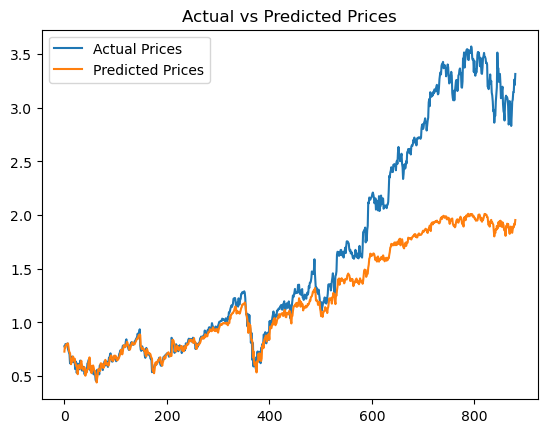

In [117]:

plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.show()

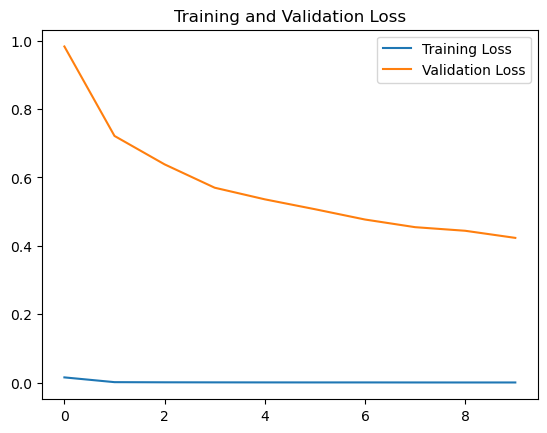

In [118]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


In [119]:

# Build a GRU model
gru_model = Sequential([
    GRU(50, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)  # Output layer for predicting the next day's 'Close' price
])

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=10,  
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the GRU model
train_loss = gru_model.evaluate(X_train, y_train, verbose=0)
test_loss = gru_model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0371 - val_loss: 0.5584
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6799e-04 - val_loss: 0.5143
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6361e-04 - val_loss: 0.4726
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5623e-04 - val_loss: 0.4485
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5854e-04 - val_loss: 0.4118
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1287e-04 - val_loss: 0.3833
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7287e-04 - val_loss: 0.3492
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7999e-04 - val_loss: 0.3249
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6114e-04 - val_loss: 0.2811
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5185e-04 - val_loss: 0.2548
Train Loss: 0.0003, Test Loss: 0.2548


In [120]:

# Evaluate on training and testing data
train_loss = gru_model.evaluate(X_train, y_train, verbose=0)
test_loss = gru_model.evaluate(X_test, y_test, verbose=0)

# Calculate RMSE
train_rmse = np.sqrt(train_loss)
test_rmse = np.sqrt(test_loss)

print(f"Train Loss (MSE): {train_loss:.4f}, Train RMSE: {train_rmse:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

from sklearn.metrics import mean_absolute_error

# Predict on test data
y_pred = gru_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")


from sklearn.metrics import r2_score

# Calculate R²
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")


Train Loss (MSE): 0.0003, Train RMSE: 0.0162
Test Loss (MSE): 0.2548, Test RMSE: 0.5048
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Absolute Error (MAE): 0.3107
R² Score: 0.7393


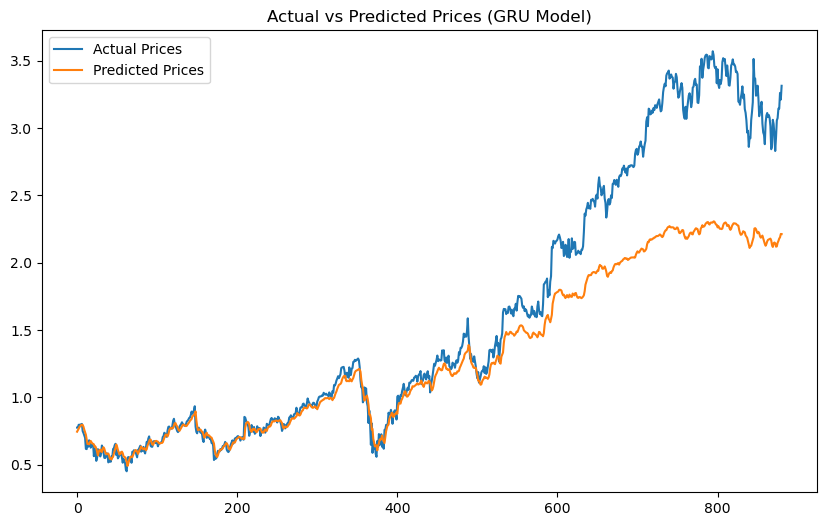

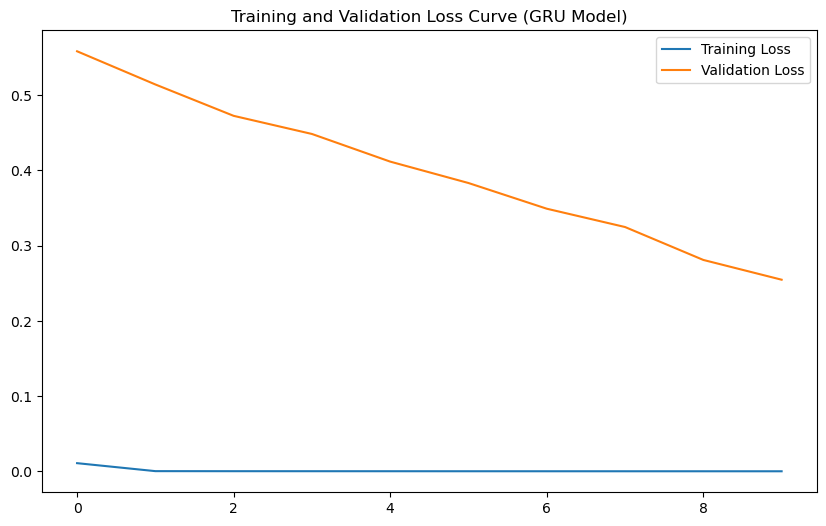

In [121]:

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.legend()
plt.title("Actual vs Predicted Prices (GRU Model)")
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(gru_history.history['loss'], label='Training Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss Curve (GRU Model)")
plt.show()


In [122]:


# Build an LSTM model
lstm_model = Sequential([
    LSTM(50, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)  # Output layer for predicting the next day's 'Close' price
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=10,  # Adjust epochs based on performance
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the LSTM model
train_loss = lstm_model.evaluate(X_train, y_train, verbose=0)
test_loss = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0221 - val_loss: 0.9762
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9975e-04 - val_loss: 0.9092
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9508e-04 - val_loss: 0.8333
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6389e-04 - val_loss: 0.7338
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7040e-04 - val_loss: 0.6584
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4544e-04 - val_loss: 0.6679
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1979e-04 - val_loss: 0.6147
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0436e-04 - val_loss: 0.5310
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7754e-04 - val_loss: 0.5112
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6294e-04 - val_loss: 0.4492
Train Loss: 0.0004, Test Loss: 0.4492


In [123]:

# Calculating RMSE
train_rmse = np.sqrt(train_loss)
test_rmse = np.sqrt(test_loss)

print(f"Train Loss (MSE): {train_loss:.4f}, Train RMSE: {train_rmse:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")
from sklearn.metrics import mean_absolute_error

# Predict on test data
y_pred = lstm_model.predict(X_test)

# Calculating MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")


# Calculate R²
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")


Train Loss (MSE): 0.0004, Train RMSE: 0.0205
Test Loss (MSE): 0.4492, Test RMSE: 0.6702
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Absolute Error (MAE): 0.4026
R² Score: 0.5404


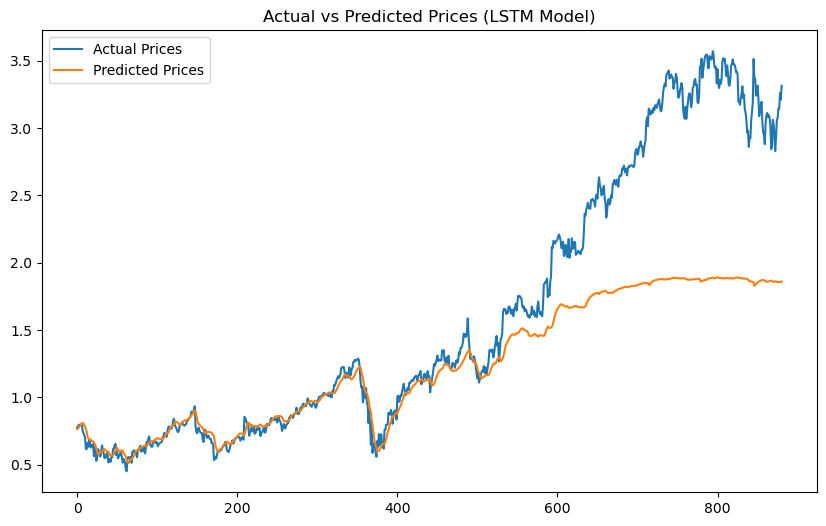

In [124]:

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.legend()
plt.title("Actual vs Predicted Prices (LSTM Model)")
plt.show()


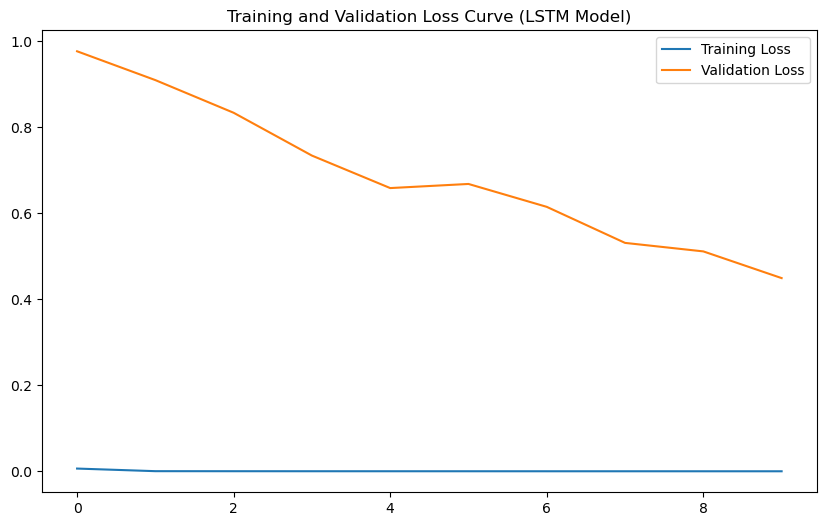

In [125]:
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss Curve (LSTM Model)")
plt.show()


In [137]:


# Define parameter grid
param_grid = {
    'units': [32, 50, 64],
    'dropout': [0.0, 0.2],
    'batch_size': [16, 32],
    'learning_rate': [0.001, 0.01],
    'epochs': [10]
}

# Function to create and compile a GRU model
def create_gru_model(units, dropout, learning_rate):
    model = Sequential([
        GRU(units, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Performing grid search
best_model = None
best_params = None
best_val_loss = float('inf')

for params in ParameterGrid(param_grid):
    model = create_gru_model(params['units'], params['dropout'], params['learning_rate'])
    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_data=(X_test, y_test),
        verbose=0
    )
    val_loss = min(history.history['val_loss'])
    print(f"Params: {params}, Validation Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_params = params

#  best parameters and validation loss
print(f"Best Params: {best_params}, Best Validation Loss: {best_val_loss:.4f}")


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: {'batch_size': 16, 'dropout': 0.0, 'epochs': 10, 'learning_rate': 0.001, 'units': 32}, Validation Loss: 0.2776
Params: {'batch_size': 16, 'dropout': 0.0, 'epochs': 10, 'learning_rate': 0.001, 'units': 50}, Validation Loss: 0.2235
Params: {'batch_size': 16, 'dropout': 0.0, 'epochs': 10, 'learning_rate': 0.001, 'units': 64}, Validation Loss: 0.1140
Params: {'batch_size': 16, 'dropout': 0.0, 'epochs': 10, 'learning_rate': 0.01, 'units': 32}, Validation Loss: 0.1244
Params: {'batch_size': 16, 'dropout': 0.0, 'epochs': 10, 'learning_rate': 0.01, 'units': 50}, Validation Loss: 0.0886
Params: {'batch_size': 16, 'dropout': 0.0, 'epochs': 10, 'learning_rate': 0.01, 'units': 64}, Validation Loss: 0.0842
Params: {'batch_size': 16, 'dropout': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'units': 32}, Validation Loss: 0.1225
Params: {'batch_size': 16, 'dropout': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'units': 50}, Validation Loss: 0.0401
Params: {'batch_size': 16, 'dropout': 0.2, 'epochs'

In [142]:
# Creating the final GRU model with the best parameters
final_gru_model = Sequential([
    GRU(50, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),  # Add dropout to prevent overfitting
    Dense(1)  # Output layer for predicting the next day's 'Close' price
])

# Compiling the model with the best learning rate
final_gru_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Training the final GRU model with the best parameters
final_history = final_gru_model.fit(
    X_train, y_train,
    epochs=10,  # Best number of epochs
    batch_size=16,  # Best batch size
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluating the final GRU model on train and test data
train_loss = final_gru_model.evaluate(X_train, y_train, verbose=0)
test_loss = final_gru_model.evaluate(X_test, y_test, verbose=0)

rmse =  np.sqrt(test_loss)

r2 = r2_score(y_actual, y_pred)

print(f"Final Train Loss (MSE): {train_loss:.4f}")
print(f"Final Test Loss (MSE): {test_loss:.4f}")
print(f"Final Test RMSE: {rmse:.4f}")
print(f"Final Test R² Score: {r2:.4f}")

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0386 - val_loss: 0.0249
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0345
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0299
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0907
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - val_loss: 0.0503
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.0697
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.0432
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 0.0363
Epoch 9/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 0.0328
Epoch 10/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.1050
Final Train Loss (MSE): 0.0010
Final Test Loss (MSE): 0.1050
Final Test RMSE: 0.3240
Final Test R² Score: 0.8679


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


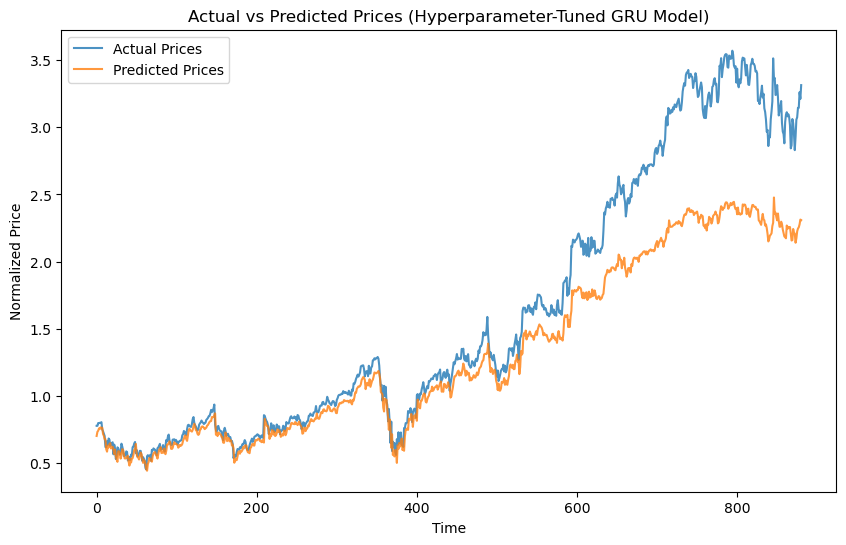

In [130]:

# Predict on test data using the final GRU model
y_pred = final_gru_model.predict(X_test)

# actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Prices', alpha=0.8)
plt.plot(y_pred, label='Predicted Prices', alpha=0.8)
plt.title("Actual vs Predicted Prices (Hyperparameter-Tuned GRU Model)")
plt.xlabel("Time")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()
